# Mandelbrot Orbit Trap Shading
- Created: October 12, 2022
- Updated: January 27, 2023
- Author:  Bill Maier

An orbit trap is a method for smooth shading fractals. The idea of an orbit trap is to measure the distance of an orbit from some reference object at each step of the iteration. That distance is then used to determine the color of that point.

In this document a line is used as the orbit trap reference.

In [1]:
using Images
using PyPlot
using LinearAlgebra

In [2]:
const MAX_ITERATIONS = 100

100

In [3]:
struct LineType
    # The two points defining the line
    p1::Complex{Float64}
    p2::Complex{Float64}
    
    # Distance between the defining points
    absdiff::Float64  # abs(p1-p2)
    
    # Constructor which sets *absdiff*
    LineType(p1::Complex{Float64}, p2::Complex{Float64}) = new(p1, p2, abs(p2-p1))
end

In [4]:
function line_dist(line::LineType, point::Complex{Float64})
    #=
    Compute the distance from a point to a line.
    =#
    d = ((imag(line.p2) - imag(line.p1))*real(point)
        - (real(line.p2) - real(line.p1))*imag(point)
        + real(line.p2)*imag(line.p1) - imag(line.p2)*real(line.p1))
    return abs(d) / line.absdiff
end

line_dist (generic function with 1 method)

In [5]:
function iter(c::Complex{Float64}, line::LineType)
    """
    Iterates the given point until the modulus of the value becomes > 2,
    or MAX_ITERATIONS is reached. Also measures the minimum distance of
    the orbit from the input line.
    
    Returns a tuple with (iterations, dist) where
        iterations = number of iterations for this point
        dist = minimum distance of the orbit to the trap
    """
    z = 0.0 + 0.0im
    dist = 9.0e20
    count = 0
    while count < MAX_ITERATIONS
        z1 = z^2 + c
        dist = min(dist, line_dist(line,z1))
        modu = abs2(z1)
        if modu > 2.0
            break
        end

        z = z1
        count += 1
    end

    return count, dist
end

iter (generic function with 1 method)

In [6]:
struct Bounds
    # Boundaries of a rectangle for viewing
    x1::Float64
    x2::Float64
    y1::Float64
    y2::Float64
end

In [7]:
function compute_mandelbrot(nx::Int, ny::Int, bound::Bounds, line::LineType)
    """
    Compute the mandelbrot set
    """
    counts = zeros(Int64,ny,nx)
    dists = zeros(Float64,ny,nx)
    
    dx = (bound.x2 - bound.x1) / nx
    dy = (bound.y2 - bound.y1) / ny

    for i = 1:nx
        x = bound.x1 + (i - 0.5)*dx
        for j = 1:ny
            y = bound.y1 + (j - 0.5)*dy
            # Invert the Y coordinates because graphics start at the
            # top with y = 0 and go down for positive values
            counts[ny-j+1,i], dists[ny-j+1,i] = iter(x + y*im, line)
        end
    end
    
    return counts, dists
end

compute_mandelbrot (generic function with 1 method)

In [8]:
function calc_image_autoscale(mapname::String, xpixels::Int64, ypixels::Int64,
        bounds::Bounds, line::LineType)
    #=
    Calculate the Mandelbrot set with a line orbit trap, and apply
    automatic color scaling to the distances to be in range [0,1].
    Then display the resulting image.
    =#
    counts, dists = compute_mandelbrot(xpixels, ypixels, bounds, line);

    # Normalize the distances in the range [0,1]
    min_dist = 1.0e20
    max_dist = 0.0
    for i in eachindex(dists[:,1]), j in eachindex(dists[1,:])
        if dists[i,j] < min_dist
            min_dist = dists[i,j]
        end
        if dists[i,j] > max_dist
            max_dist = dists[i,j]
        end
    end

    # Compute the color scaling and apply to the image
    scale = 1.0 / (max_dist - min_dist)
    for i in eachindex(dists[:,1]), j in eachindex(dists[1,:])
        dists[i,j] = scale*(dists[i,j] + min_dist)
    end

    imshow(dists, cmap=mapname, extent=[0, xpixels, 0, ypixels]);
end

calc_image_autoscale (generic function with 1 method)

Here are list of colormap names:

'Blues', 'BrBG', 'BuGn', 'BuPu', 'CMRmap', 'GnBu', 'Greens', 'Greys', 'OrRd', 'Oranges', 'PRGn', 'PiYG', 'PuBu', 'PuBuGn', 'PuOr', 'PuRd', 'Purples', 'RdBu', 'RdGy', 'RdPu', 'RdYlBu', 'RdYlGn', 'Reds', 'Spectral', 'Wistia', 'YlGn', 'YlGnBu', 'YlOrBr', 'YlOrRd', 'afmhot', 'autumn', 'binary', 'bone', 'brg', 'bwr', 'cool', 'coolwarm', 'copper', 'cubehelix', 'flag', 'gist_earth', 'gist_gray', 'gist_heat', 'gist_ncar', 'gist_rainbow', 'gist_stern', 'gist_yarg', 'gnuplot', 'gnuplot2', 'gray', 'hot', 'hsv', 'jet', 'nipy_spectral', 'ocean', 'pink', 'prism', 'rainbow', 'seismic', 'spring', 'summer', 'terrain', 'winter', 'Accent', 'Dark2', 'Paired', 'Pastel1', 'Pastel2', 'Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b', 'tab20c'

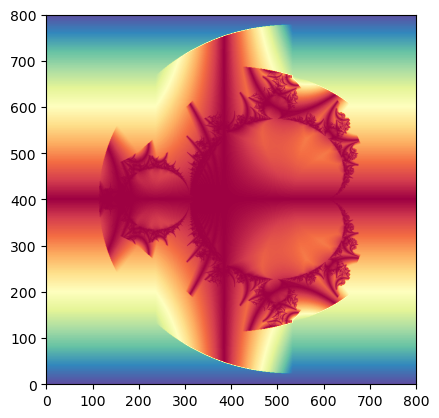

In [9]:
xpixels = 800
ypixels = 800
line = LineType(-1.0+0im, 1.0+0im)
bounds = Bounds(-1.8, 0.9, -1.5, 1.5)
calc_image_autoscale("Spectral", xpixels, ypixels, bounds, line);

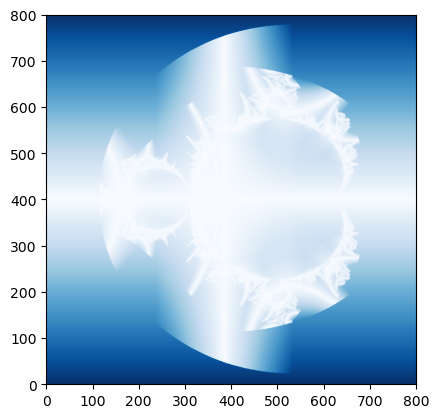

In [10]:
calc_image_autoscale("Blues", xpixels, ypixels, bounds, line);

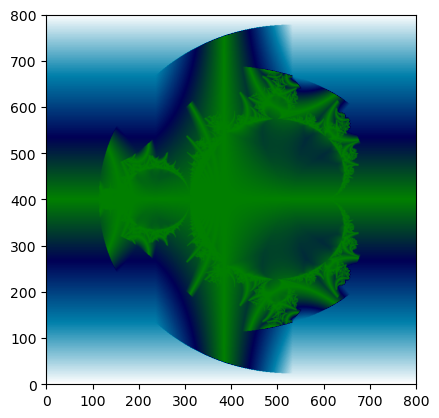

In [11]:
calc_image_autoscale("ocean", xpixels, ypixels, bounds, line);

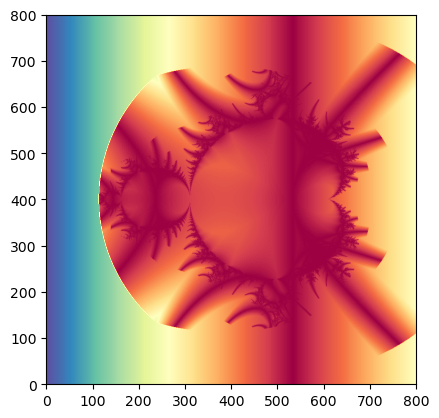

In [12]:
line = LineType(0.0-1.0im, 0.0+1.0im)
calc_image_autoscale("Spectral", xpixels, ypixels, bounds, line);

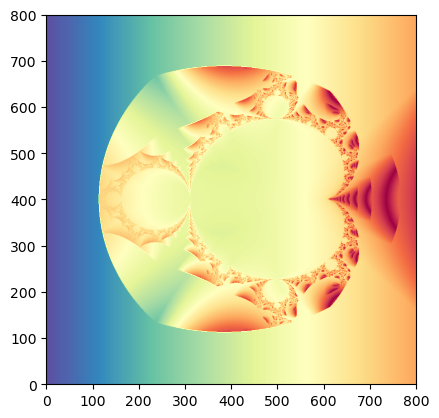

In [13]:
line = LineType(2.0-1.0im, 2.0+1.0im)
calc_image_autoscale("Spectral", xpixels, ypixels, bounds, line);

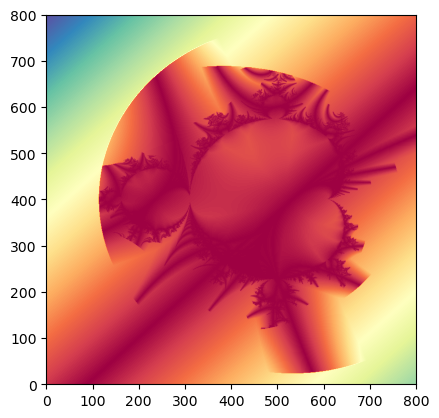

In [14]:
line = LineType(-1.0+-1.0im, 1.0+1.0im)
calc_image_autoscale("Spectral", xpixels, ypixels, bounds, line);

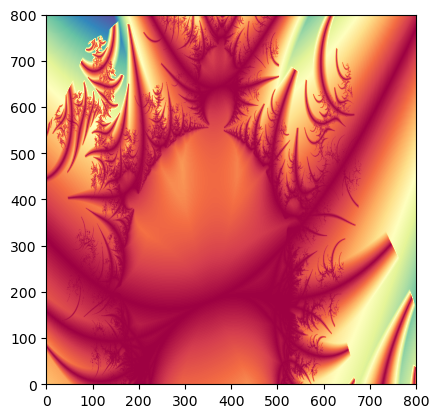

In [15]:
line = LineType(-1.0+-1.0im, 1.0+1.0im)
bounds = Bounds(-0.3, 0.1, 0.7, 0.9)
calc_image_autoscale("Spectral", xpixels, ypixels, bounds, line);

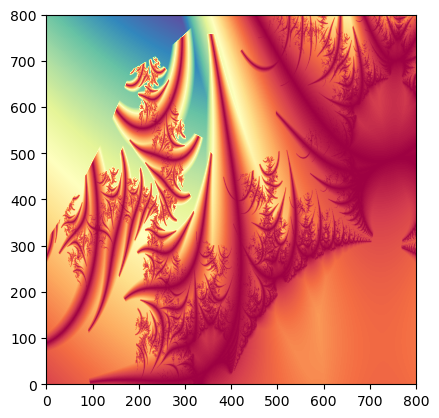

In [16]:
line = LineType(-1.0+-1.0im, 1.0+1.0im)
bounds = Bounds(-0.3, -0.1, 0.8, 0.9)
calc_image_autoscale("Spectral", xpixels, ypixels, bounds, line);